## ThyroidAI: Diagnostic Predictive Modeling for Thyroid Disease
AAI501 Final Project

Halladay Kinsey, Stephanie Tabares 

In [1]:
# Import libraries
from itertools import cycle
from scipy import interp

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, f1_score, hamming_loss,
                             jaccard_score, precision_recall_fscore_support,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.tree import plot_tree

## Data Source Description 

**Overview:** The Thyroid Disease dataset is a collection of records from several sources, compiled to facilitate the development and assessment of AI diagnostic tools for thyroid disorders. The dataset contains various attributes ranging from hormonal levels to patient history. The primary aim is to assist in the accurate diagnosis of thyroid disease, which include hypothyroidism, hyperthyroidism and healthy controls. 

**Dataset Specifics:** 

**Total Attributes:** Approximately 30 (varies by subset)

**Attributes Used in Studies:** Varies, with common focus of TSH, T3, TT4, T4U and FTI levels

**Primary Goal:** To accurately diagnose different types of thyroid conditions, including euthyroid (healthy), hypothyroid and hyperthyroid states. 

**Missing Values:** Yes, instances of missing values are present accross various attributes, requiring careful preprocessing for analysis. 

**Database Version:** The dataset is comprised of several subsets, each with varying attribute inclusion and sourced from different studies, with the most commonly used being the "allhypo" and "allhyper" subsets. 

**Additional Resouces:** Some subsets include cost-sensitive learning attributes, which are essential for certain types of analysis focusing on the economic aspect of diagnosis. 

**Pulication Reference:** Quinlan, J.R. (1986). Induction of Decision Trees. *Machine Learning*, 1(1), 81-106. This publication discussess the development of decision tree algorithms that have been widely applied to the Thyroid Disease dataset. 

## Import Data

In [2]:
# URL for UCI dataset
base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/"

# Files to load
files = [
    'allbp.data', 'allhyper.data', 'allhypo.data', 'allrep.data', 
    'ann-train.data', 'ann-test.data', 'dis.data', 'sick.data', 
    'sick-euthyroid.data', 'thyroid0387.data'
]
column_names = [
    'age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant', 
    'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 
    'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH', 'T3_measured', 'T3', 
    'TT4_measured', 'TT4', 'T4U_measured', 'T4U', 'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 
    'referral_source', 'target', 'patient_id'
]

# Create dataframe 
df = pd.DataFrame()

for file_name in files:
    file_url = base_url + file_name
    df = pd.read_csv(file_url, header=None, names=column_names, na_values='?')
    df = pd.concat([df, df], ignore_index=True)

## Preliminary Data Exploration 

In [3]:
print('Data Info')
display(df.info())

print('Data Head')
display(df.head())

print('Data Describe')
display(df.describe())

print("Data Types")
display(df.dtypes)

nan_counts_per_column = df.isnull().sum()
print(nan_counts_per_column)

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18344 entries, 0 to 18343
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  18344 non-null  int64  
 1   sex                  17730 non-null  object 
 2   on_thyroxine         18344 non-null  object 
 3   query_on_thyroxine   18344 non-null  object 
 4   on_antithyroid_meds  18344 non-null  object 
 5   sick                 18344 non-null  object 
 6   pregnant             18344 non-null  object 
 7   thyroid_surgery      18344 non-null  object 
 8   I131_treatment       18344 non-null  object 
 9   query_hypothyroid    18344 non-null  object 
 10  query_hyperthyroid   18344 non-null  object 
 11  lithium              18344 non-null  object 
 12  goitre               18344 non-null  object 
 13  tumor                18344 non-null  object 
 14  hypopituitary        18344 non-null  object 
 15  psych                18344

None

Data Head


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-[840801013],NaN
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-[840801014],NaN
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-[840801042],NaN
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-[840803046],NaN
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S[840803047],NaN


Data Describe


,age,TSH,T3,TT4,T4U,FTI,TBG,patient_id
count,18344.000000,16660.000000,13136.000000,17460.000000,16726.000000,16740.000000,698.000000,0.0
mean,73.555822,5.218403,1.970629,108.700305,0.976056,113.640746,29.870057,NaN
std,1183.944444,24.183280,0.887545,37.521596,0.200354,41.550408,21.065376,NaN
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000,0.100000,NaN
25%,37.000000,0.460000,1.500000,87.000000,0.860000,93.000000,21.000000,NaN
50%,55.000000,1.400000,1.900000,104.000000,0.960000,109.000000,26.000000,NaN
75%,68.000000,2.700000,2.300000,126.000000,1.067500,128.000000,31.000000,NaN
max,65526.000000,530.000000,18.000000,600.000000,2.330000,881.000000,200.000000,NaN


Data Types


age                      int64
sex                     object
on_thyroxine            object
query_on_thyroxine      object
on_antithyroid_meds     object
sick                    object
pregnant                object
thyroid_surgery         object
I131_treatment          object
query_hypothyroid       object
query_hyperthyroid      object
lithium                 object
goitre                  object
tumor                   object
hypopituitary           object
psych                   object
TSH_measured            object
TSH                    float64
T3_measured             object
T3                     float64
TT4_measured            object
TT4                    float64
T4U_measured            object
T4U                    float64
FTI_measured            object
FTI                    float64
TBG_measured            object
TBG                    float64
referral_source         object
target                  object
patient_id             float64
dtype: object

age                        0
sex                      614
on_thyroxine               0
query_on_thyroxine         0
on_antithyroid_meds        0
sick                       0
pregnant                   0
thyroid_surgery            0
I131_treatment             0
query_hypothyroid          0
query_hyperthyroid         0
lithium                    0
goitre                     0
tumor                      0
hypopituitary              0
psych                      0
TSH_measured               0
TSH                     1684
T3_measured                0
T3                      5208
TT4_measured               0
TT4                      884
T4U_measured               0
T4U                     1618
FTI_measured               0
FTI                     1604
TBG_measured               0
TBG                    17646
referral_source            0
target                     0
patient_id             18344
dtype: int64


## Cleaning and adding context to the data

In [4]:
column_metadata = {
    'age': {
        'Role': 'Feature',
        'Type': 'Integer',
        'Description': 'Age of the patient',
        'Units': 'years',
    },
    'sex': {
        'Role': 'Feature',
        'Type': 'Categorical',
        'Description': 'Sex the patient identifies with',
        'Units': 'category',
    },
    'on_thyroxine': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient is on thyroxine medication',
        'Units': 'binary',
    },
    'query_on_thyroxine': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient has queried about thyroxine medication',
        'Units': 'binary',
    },
    'on_antithyroid_meds': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient is on antithyroid medications',
        'Units': 'binary',
    },
    'sick': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient is currently sick',
        'Units': 'binary',
    },
    'pregnant': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient is pregnant',
        'Units': 'binary',
    },
    'thyroid_surgery': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient has undergone thyroid surgery',
        'Units': 'binary',
    },
    'I131_treatment': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient is undergoing I131 treatment',
        'Units': 'binary',
    },
    'query_hypothyroid': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient believes they have hypothyroid',
        'Units': 'binary',
    },
    'query_hyperthyroid': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient believes they have hyperthyroid',
        'Units': 'binary',
    },
    'lithium': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient is taking lithium',
        'Units': 'binary',
    },
    'goitre': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient has goitre',
        'Units': 'binary',
    },
    'tumor': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient has a tumor',
        'Units': 'binary',
    },
    'hypopituitary': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient has a hypopituitary condition',
        'Units': 'binary',
    },
    'psych': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether the patient has a psychiatric condition',
        'Units': 'binary',
    },
    'TSH_measured': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether TSH level was measured',
        'Units': 'binary',
    },
    'TSH': {
        'Role': 'Feature',
        'Type': 'Float',
        'Description': 'TSH level in the blood',
        'Units': '',
    },
    'T3_measured': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether T3 level was measured',
        'Units': 'binary',
    },
    'T3': {
        'Role': 'Feature',
        'Type': 'Float',
        'Description': 'T3 level in the blood',
        'Units': '',
    },
    'TT4_measured': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether TT4 level was measured',
        'Units': 'binary',
    },
    'TT4': {
        'Role': 'Feature',
        'Type': 'Float',
        'Description': 'TT4 level in the blood',
        'Units': '',
    },
    'T4U_measured': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'Whether T4U level was measured',
        'Units': 'binary',
    },
    'T4U': {
        'Role': 'Feature',
        'Type': 'Float',
        'Description': 'T4U level in blood from lab work',
        'Units': '',
    },
    'FTI_measured': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'whether FTI was measured in the blood',
        'Units': 'binary',
    },
    'FTI': {
        'Role': 'Feature',
        'Type': 'Float',
        'Description': 'FTI level in blood from lab work',
        'Units': '',
    },
    'TBG_measured': {
        'Role': 'Feature',
        'Type': 'Boolean',
        'Description': 'whether TBG was measured in the blood',
        'Units': 'binary',
            },
    'TBG': {
        'Role': 'Feature',
        'Type': 'Float',
        'Description': 'TBG level in blood from lab work',
        'Units': '',
    },
    'referral_source': {
        'Role': 'Feature',
        'Type': 'String',
        'Description': '',
        'Units': '',
    },
    'target': {
        'Role': 'Target',
        'Type': 'Categorical',
        'Description': 'Diagnosed thyroid condition, encoded as letters',
        'Units': 'category',
        'Categories': {
            'A': 'hyperthyroid',
            'B': 'T3 toxic hyperthyroid',
            'C': 'toxic goitre hyperthyroid',
            'D': 'secondary toxic hyperthyroid',
            'E': 'hypothyroid',
            'F': 'primary hypothyroid',
            'G': 'compensated hypothyroid',
            'H': 'secondary hypothyroid',
            'I': 'increased binding protein',
            'J': 'decreased binding protein',
            'L': 'consistent with replacement therapy',
            'M': 'underreplaced',
            'N': 'overreplaced',
            'O': 'antithyroid drugs prescribed',
            'P': 'I131 treatment',
            'Q': 'surgery',
            'R': 'discordant assay results',
            'S': 'elevated TBG',
            'T': 'elevated thyroid hormones',  
        } 
    },
    'patient_id': {
        'Role': 'Feature',
        'Type': 'String',
        'Description': 'unique id of the patient',
        'Units': '',
    }
}

df.attrs['column_metadata'] = column_metadata 

Columns ending with '_measured' are highly skewed boolean variables recording whether or not a hormone was detected in the patient's blood. Because the levels of the performed tests are also included, we can safely disregard these variables. Additionally, the variables 'patient_id' and 'referral_source' are confidential, non-medical patient information. They are not relevant to the purpose of this research and have been excluded from further analysis. Finally,'query_on_thyroxine' is a redundant variable that matches the same answers as the 'on_thyroxine' variable. 

In [5]:
# Drop all unnecessary columns
measured_columns = [col for col in df.columns if col.endswith('_measured')]
df.drop(measured_columns + ['patient_id', 'T3', 'referral_source', 'TBG', 'query_on_thyroxine'], axis=1, inplace=True)

The variable 'target' is a disease diagnosis variable with 30 different unique combinations of possible diagnoses. It has been split into separate one-hot-encoded columns for easy data handling. 

In [6]:
# Clean target variable and one-hot encode disease diagnosis
df['target'] = df['target'].str.replace(r'[\[\]0-9]', '', regex=True).str.split('|').str[0]
target_dummies = pd.get_dummies(df['target'], prefix='Diagnosis')
df = df.join(target_dummies).drop('target', axis=1)

All binary variables with the values 't' and 'f' were changed to numeric columns in which true=1 and false=0. Sex is a binary variable with the values 'M' and 'F' which have been encoded as male=1 and female=0. 

In [7]:
# Impute missing values
df['sex'] = df['sex'].fillna(df['sex'].mode()[0]).map({'M': 1, 'F': 0})
for column in ['TSH', 'TT4', 'T4U', 'FTI']:
    df[column].fillna(df[column].median(), inplace=True)

# Convert binary columns to 0/1
binary_columns = ['on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant',
                  'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 
                  'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych']
for col in binary_columns:
    df[col] = df[col].map({'t': 1, 'f': 0})

# Convert columns to numeric and handle non-numeric values
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [8]:
# Converting diagnosis boolean columns to integers
diagnosis_cols = [col for col in df.columns if col.startswith('Diagnosis_')]

df[diagnosis_cols] = df[diagnosis_cols].astype(int)

In [9]:
# Re-examine data 
print(df.head())

   age  sex  on_thyroxine  on_antithyroid_meds  sick  pregnant  \
0   29    0             0                    0     0         0   
1   29    0             0                    0     0         0   
2   41    0             0                    0     0         0   
3   36    0             0                    0     0         0   
4   32    0             0                    0     0         0   

   thyroid_surgery  I131_treatment  query_hypothyroid  query_hyperthyroid  \
0                0               0                  1                   0   
1                0               0                  0                   0   
2                0               0                  0                   1   
3                0               0                  0                   0   
4                0               0                  0                   0   

   ...  Diagnosis_M  Diagnosis_MI  Diagnosis_MK  Diagnosis_N  Diagnosis_O  \
0  ...            0             0             0            0   

## Exploratory Data Analysis

In [10]:
# 'X' contains all features except one-hot encoded target columns
X = df.drop(columns=target_dummies.columns)

# 'y' contains all one-hot encoded target columns
y = target_dummies

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Create the OneVsRestClassifier using MLPClassifier
ovr_classifier = OneVsRestClassifier(MLPClassifier())

# Train the classifier
ovr_classifier.fit(X_train, y_train)

# Predict on test data
predictions = ovr_classifier.predict(X_test)

In [12]:
# Initialize classifiers for comparison 
svm_classifier = OneVsRestClassifier(SVC())
logreg_classifier = OneVsRestClassifier(LogisticRegression())
rf_classifier = OneVsRestClassifier(RandomForestClassifier())

# Dictionary to hold models
classifiers = {
    "Neural Network": ovr_classifier,
    "SVM": svm_classifier,
    "Logistic Regression": logreg_classifier,
    "Random Forest": rf_classifier,
}

# Dictionary to store performance metrics for each model
performance_metrics = {
    "Jaccard Score": {},
    "Accuracy Score": {},
    "Hamming Loss": {}
}

# Train and evaluate models
for model_name, model in classifiers.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics and store them in dictionaries
    performance_metrics["Jaccard Score"][model_name] = jaccard_score(y_test, y_pred, average='samples')
    performance_metrics["Accuracy Score"][model_name] = accuracy_score(y_test, y_pred)
    performance_metrics["Hamming Loss"][model_name] = hamming_loss(y_test, y_pred)

# Print performance metrics
for metric, scores in performance_metrics.items():
    print(metric)
    for model_name, score in scores.items():
        print(f"{model_name}: {score:.4f}")
    print()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Jaccard Score
Neural Network: 0.7983
SVM: 0.7536
Logistic Regression: 0.7646
Random Forest: 0.9542

Accuracy Score
Neural Network: 0.7915
SVM: 0.7536
Logistic Regression: 0.7563
Random Forest: 0.9537

Hamming Loss
Neural Network: 0.0112
SVM: 0.0162
Logistic Regression: 0.0135
Random Forest: 0.0025



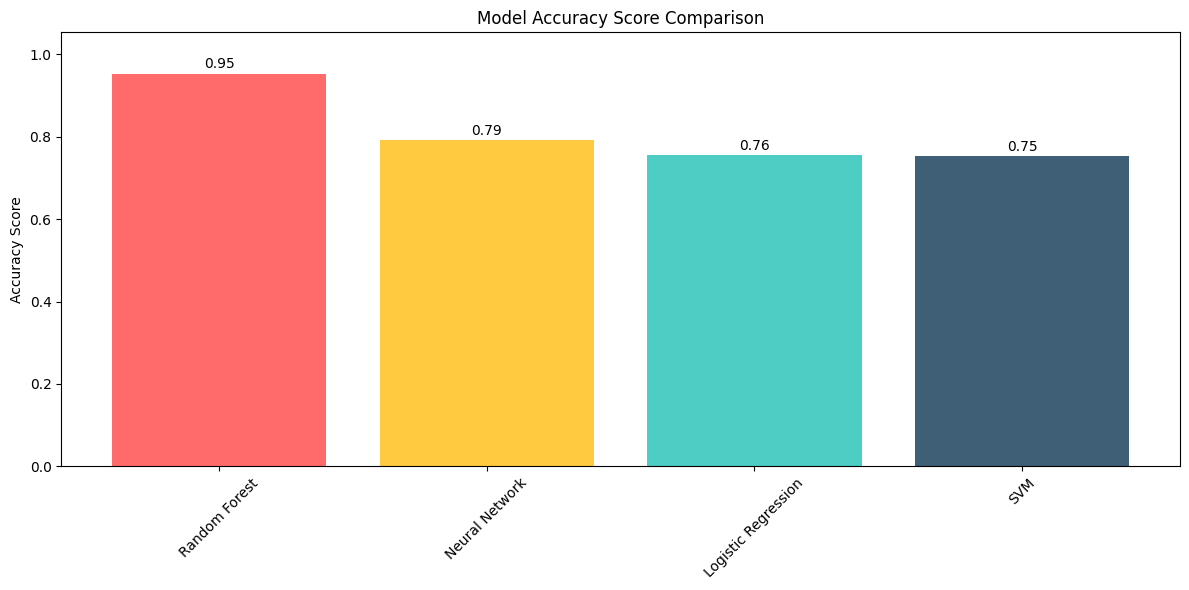

In [13]:
# Plot accuracy
metric_to_plot = "Accuracy Score"
model_names = list(performance_metrics[metric_to_plot].keys())
scores = list(performance_metrics[metric_to_plot].values())

# Sort models based on score
sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
sorted_models = [model_names[i] for i in sorted_indices]
sorted_scores = [scores[i] for i in sorted_indices]

colors = ["#FF6B6B", "#FFC940", "#4ECDC4", "#3E5F76", "#6D9EA0", "#D4E5E2"]
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_models, sorted_scores, color=colors[:len(sorted_models)])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom')

plt.ylabel(metric_to_plot.replace('_', ' '))
plt.title(f"Model {metric_to_plot.replace('_', ' ')} Comparison")
plt.ylim([0, max(sorted_scores) + 0.1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Binary Classification for Target Variable: Disease vs No Disease
Although we are getting an extremely high random forest accuracy score, the bias towards 'no disease' in the target variable may be creating model bias. First, we will try splitting the target variable into a binary classification between 'disease' and 'no disease'. Currently, the variable 'target' is split into 30 one-hot-encoded columns. In order to perform the binary classification, we will create a new binary target column and exclude the one-hot-encoded columns from this analysis.

In [14]:
if 'Diagnosis_-' in df.columns:
    # Create a binary target where 'Diagnosis_-' equals 0 (No Disease) and any other Diagnosis equals 1 (Disease)
    df['binary_target'] = 1 - df['Diagnosis_-'].astype(int)

    # Define X and Y 
    X = df.drop(columns=df.filter(like='Diagnosis_').columns.tolist() + ['binary_target'])
    y_binary = df['binary_target']

    if df['binary_target'].isnull().any():
        print("NaN values found in binary_target")

    # Train-test split
    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X, y_binary, 
        test_size=0.2, 
        stratify=y_binary,
        random_state=42
    )
else:
    raise ValueError("The 'Diagnosis_-' column was not found in the dataframe.")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


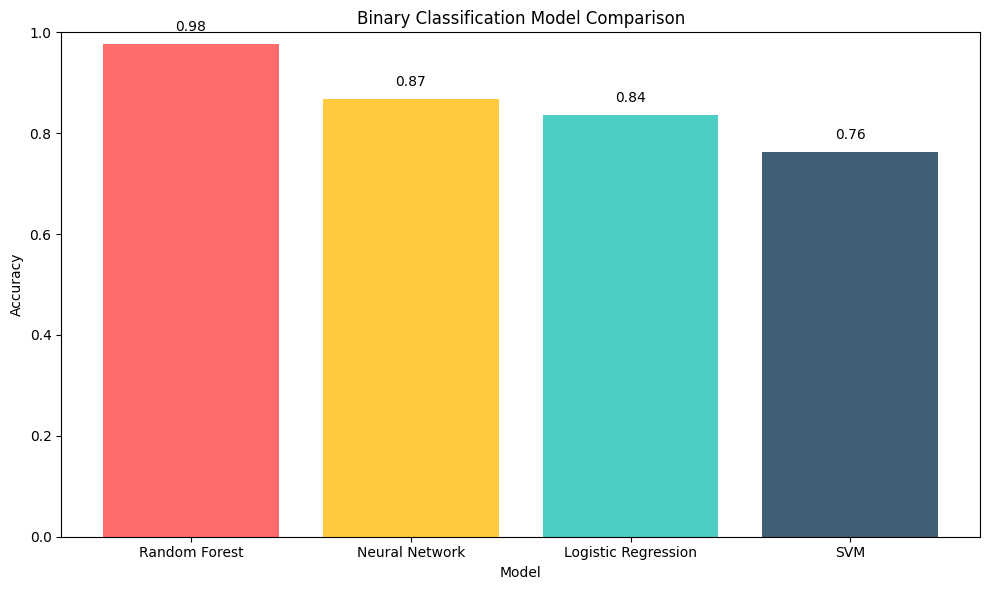

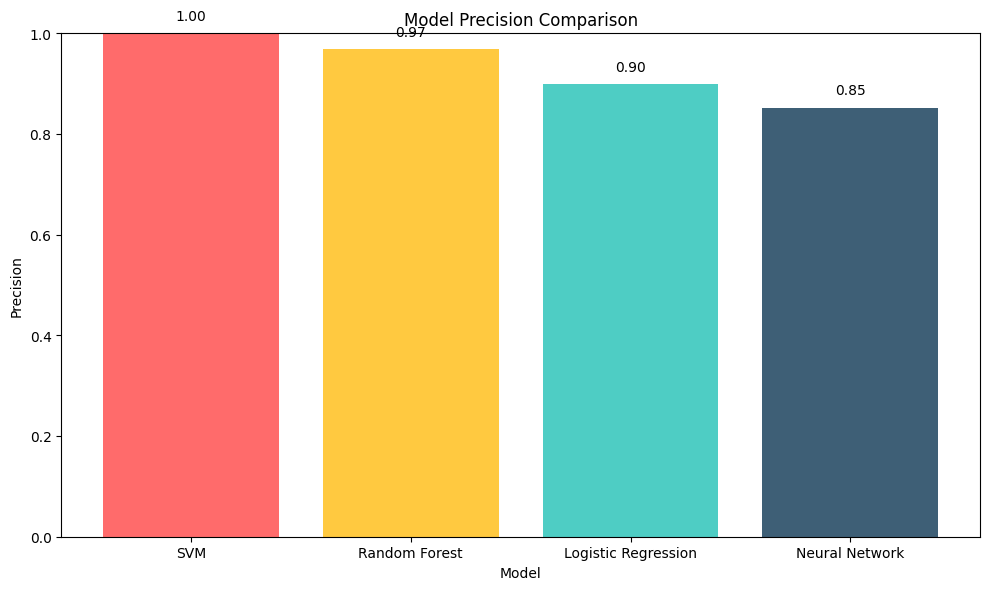

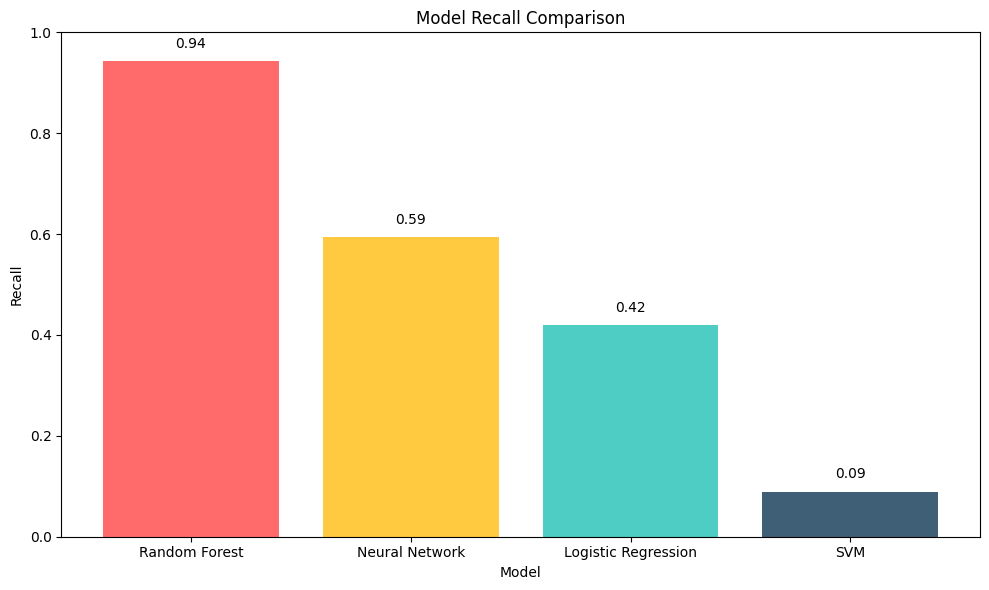

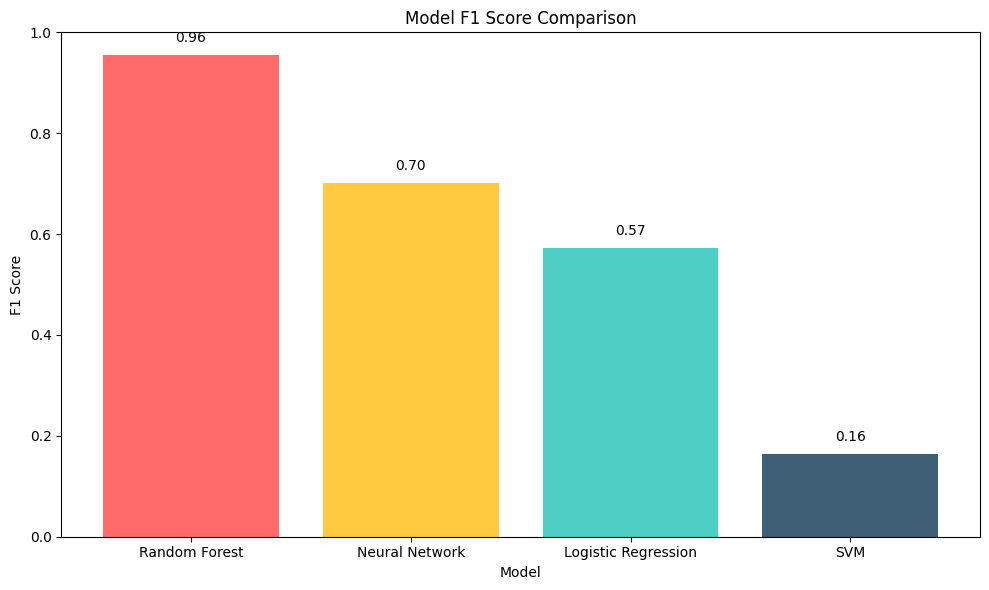

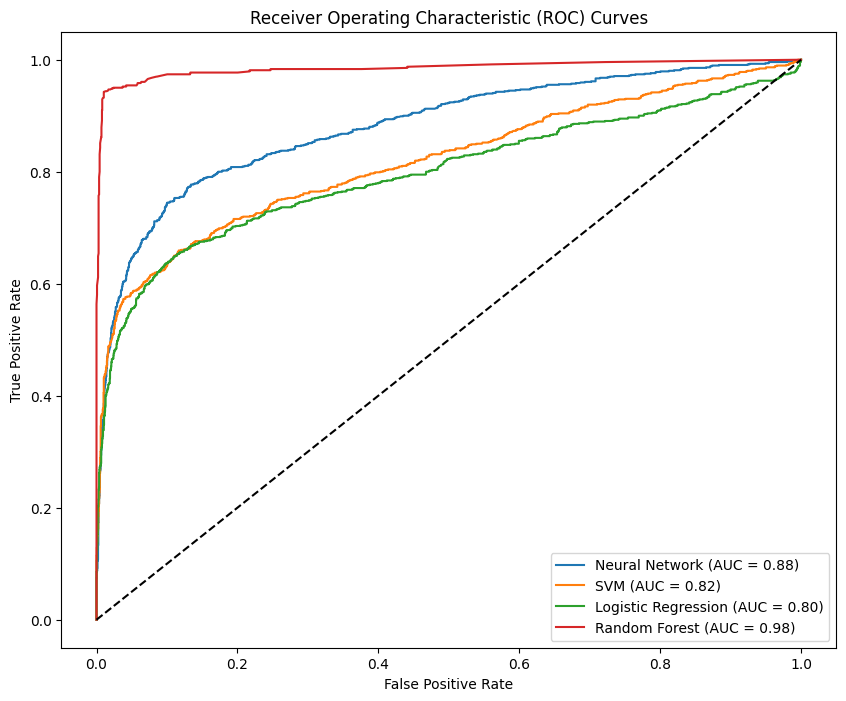

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Model                                                                 
Neural Network       0.866994   0.852239  0.594792  0.700613  0.881330
SVM                  0.761788   1.000000  0.089583  0.164436  0.818465
Logistic Regression  0.835923   0.899554  0.419792  0.572443  0.797352
Random Forest        0.976833   0.967914  0.942708  0.955145  0.984777


In [15]:
# Define models
models = {
    "Neural Network": MLPClassifier(max_iter=1000),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier()
}

# Dictionary to store metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
    'Confusion Matrix': [],
    'FPR': [],
    'TPR': []
}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_bin, y_train_bin)
    
    predictions = model.predict(X_test_bin)
    probabilities = model.predict_proba(X_test_bin)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_bin)
    
    accuracy = accuracy_score(y_test_bin, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_bin, predictions, average='binary')
    roc_auc = roc_auc_score(y_test_bin, probabilities)
    fpr, tpr, _ = roc_curve(y_test_bin, probabilities)
    
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1)
    metrics['ROC AUC'].append(roc_auc)
    metrics['Confusion Matrix'].append(confusion_matrix(y_test_bin, predictions))
    metrics['FPR'].append(fpr)
    metrics['TPR'].append(tpr)

metrics_df = pd.DataFrame(metrics).set_index('Model')

# Function to plot metrics
def plot_metric(dataframe, metric, title, ylabel, color_palette):
    sorted_df = dataframe.sort_values(by=metric, ascending=False)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(sorted_df.index, sorted_df[metric], color=color_palette[:len(sorted_df)])
    plt.xlabel('Model')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim([0, 1])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

# Plot metrics
plot_metric(metrics_df, 'Accuracy', 'Binary Classification Model Comparison', 'Accuracy', ['#FF6B6B', '#FFC940', '#4ECDC4', '#3E5F76'])
plot_metric(metrics_df, 'Precision', 'Model Precision Comparison', 'Precision', ['#FF6B6B', '#FFC940', '#4ECDC4', '#3E5F76'])
plot_metric(metrics_df, 'Recall', 'Model Recall Comparison', 'Recall', ['#FF6B6B', '#FFC940', '#4ECDC4', '#3E5F76'])
plot_metric(metrics_df, 'F1 Score', 'Model F1 Score Comparison', 'F1 Score', ['#FF6B6B', '#FFC940', '#4ECDC4', '#3E5F76'])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name in models.keys():
    plt.plot(metrics_df.loc[model_name, 'FPR'], metrics_df.loc[model_name, 'TPR'], label=f'{model_name} (AUC = {metrics_df.loc[model_name, "ROC AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Print summary df
print(metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']])

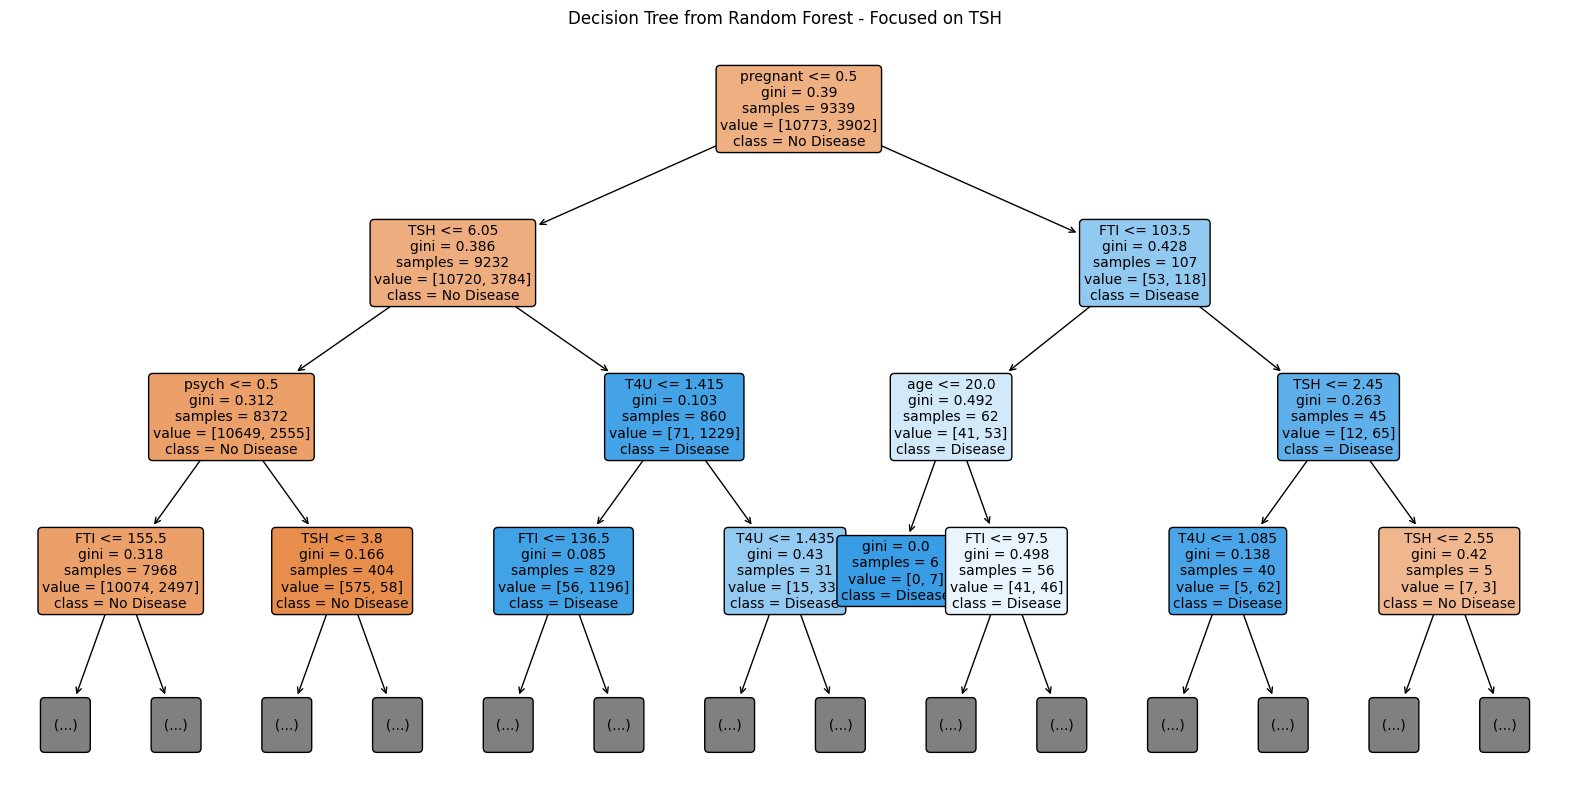

In [16]:
# Visualize 1st tree for RF 
rf_classifier = models['Random Forest']

selected_tree = rf_classifier.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(rf_classifier.estimators_[0], 
          feature_names=X_train_bin.columns, 
          class_names=['No Disease', 'Disease'], 
          filled=True, 
          rounded=True, 
          max_depth=3, 
          fontsize=10)
plt.title("Decision Tree from Random Forest - Focused on TSH")
plt.show()

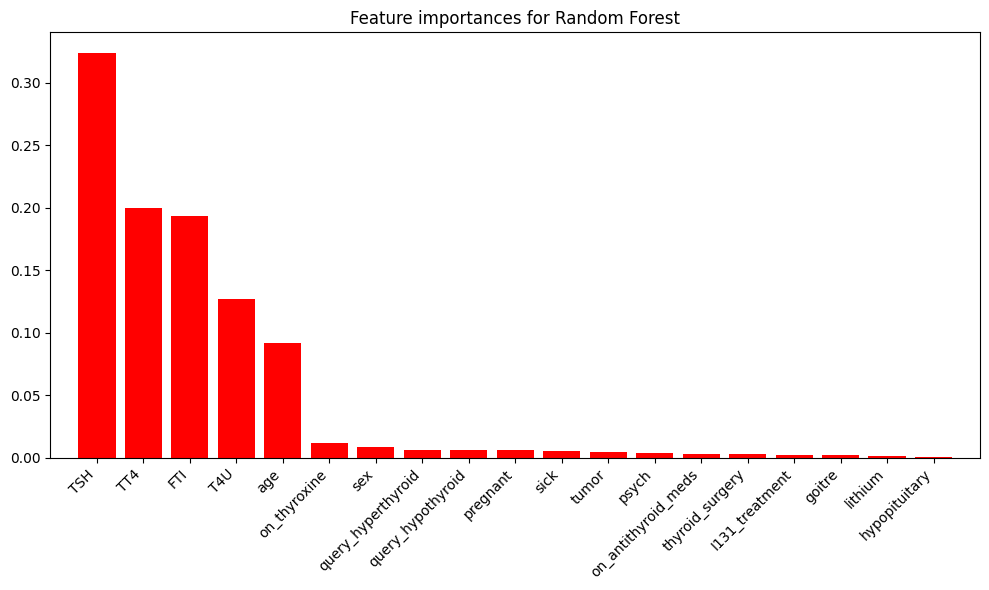

In [17]:
# Finding feature importance for models that have built-in
feature_importances = {}

for model_name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        if not hasattr(model, 'is_fitted_') or not model.is_fitted_:
            model.fit(X_train_bin, y_train_bin)
            
        feature_importances[model_name] = model.feature_importances_

# Plot feature importance
for model_name, importances in feature_importances.items():
    indices = np.argsort(importances)[::-1]
    
    # Map indices to feature names
    sorted_feature_names = X_train_bin.columns[indices]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature importances for {model_name}")
    
    plt.bar(range(X_train_bin.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train_bin.shape[1]), sorted_feature_names, rotation=45, ha='right')
    
    plt.xlim([-1, X_train_bin.shape[1]])
    plt.tight_layout() 
    plt.show()

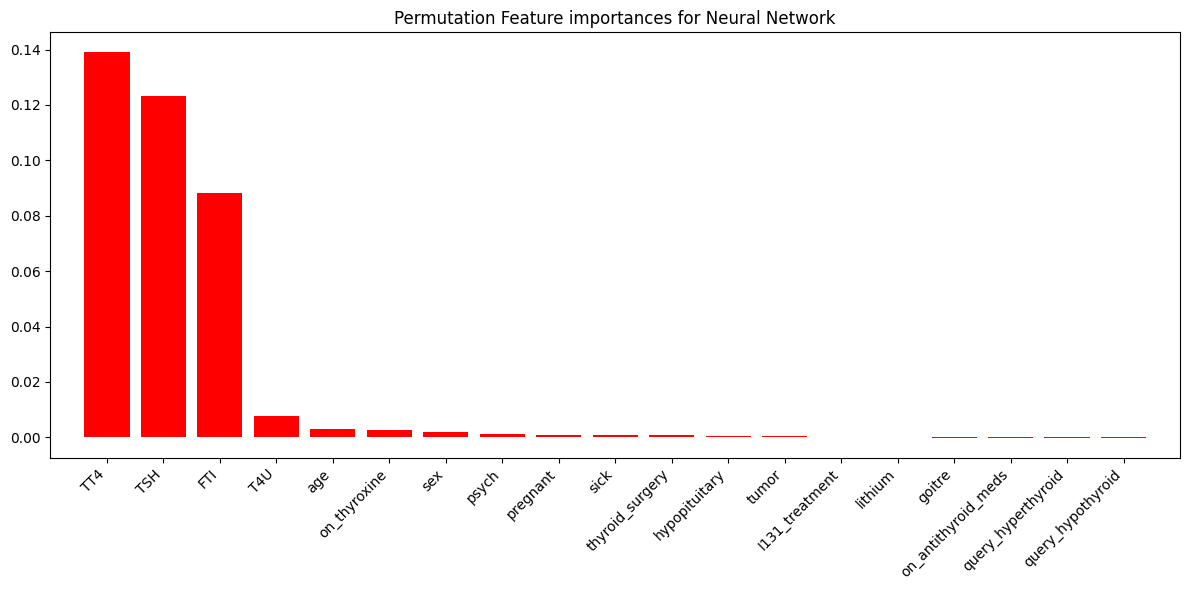

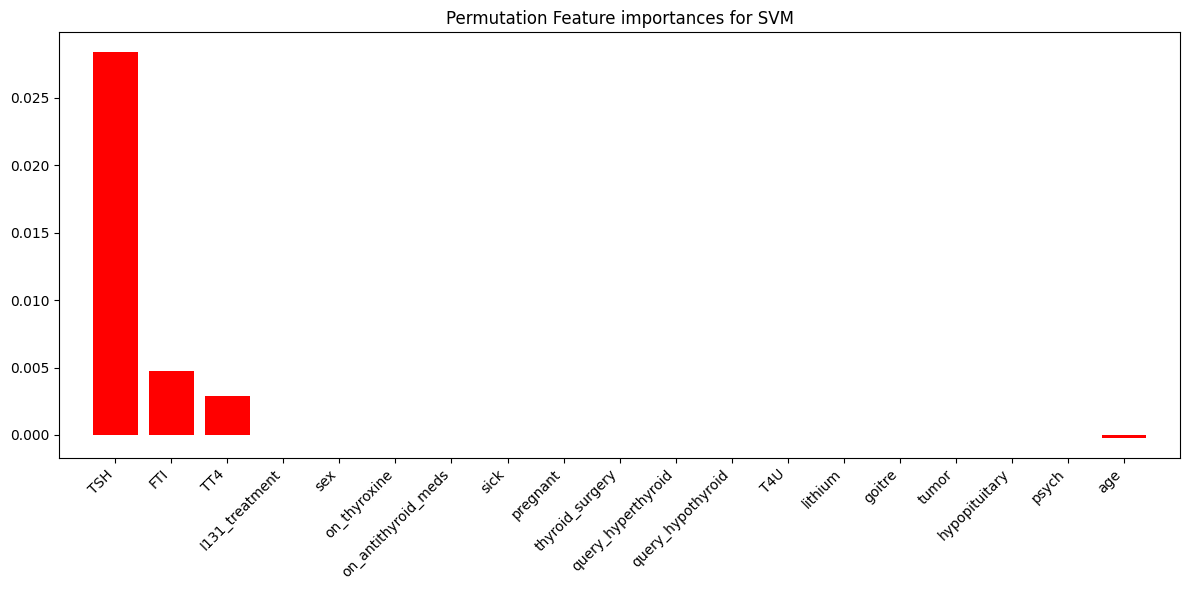

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


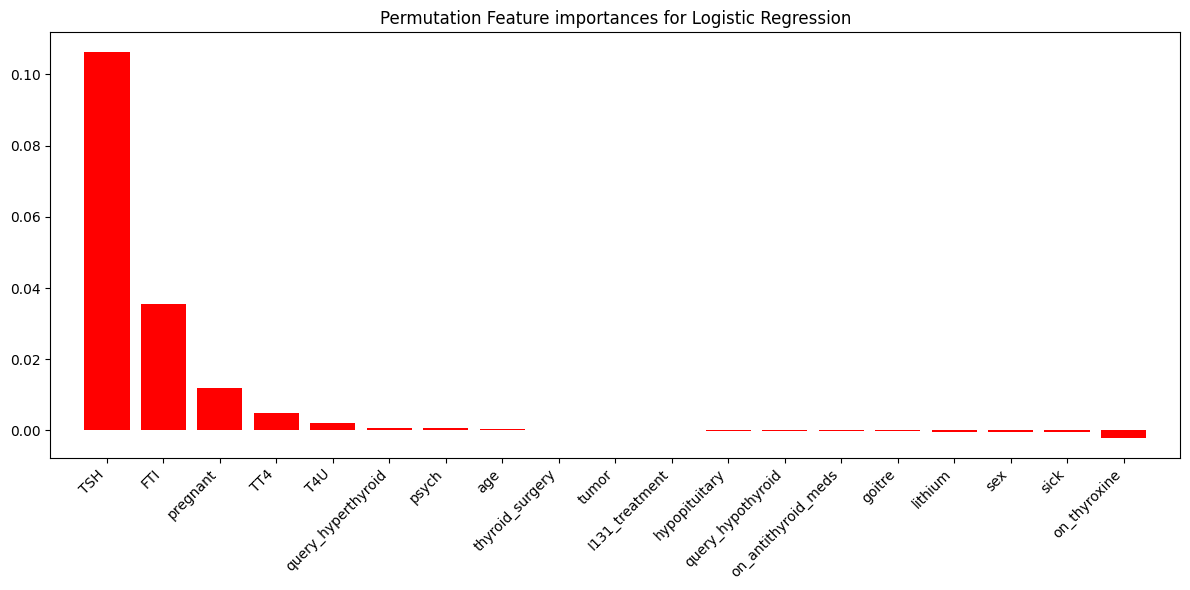

In [18]:
# Finding permutation importance for models without feature importance
for model_name, model in models.items():
    if not hasattr(model, 'feature_importances_'):
        if not hasattr(model, 'is_fitted_') or not model.is_fitted_:
            model.fit(X_train_bin, y_train_bin)
        
        result = permutation_importance(model, X_test_bin, y_test_bin, n_repeats=10, random_state=42, n_jobs=-1)
        feature_importances[model_name] = result.importances_mean

        # Map indices to feature names
        indices = np.argsort(feature_importances[model_name])[::-1]
        sorted_feature_names = X_train_bin.columns[indices]

        plt.figure(figsize=(12, 6))
        plt.title(f"Permutation Feature importances for {model_name}")
        
        plt.bar(range(X_train_bin.shape[1]), feature_importances[model_name][indices], color="r", align="center")
        plt.xticks(range(X_train_bin.shape[1]), sorted_feature_names, rotation=45, ha='right')
        
        plt.xlim([-1, X_train_bin.shape[1]])
        plt.tight_layout()
        plt.show()

## Random Forest Classification: Male vs Female
We performed a gender-based analysis using a Random Forest classifier to assess feature importance of how levels of hormones like TSH, TT4, and FT1 contribute to the machine learning prediction of thyroid disease. We used partial dependence plots (PDPs) to understand the relationship between hormones and the predicted probability of disease.

Random Forest trained for males.
Random Forest trained for females.


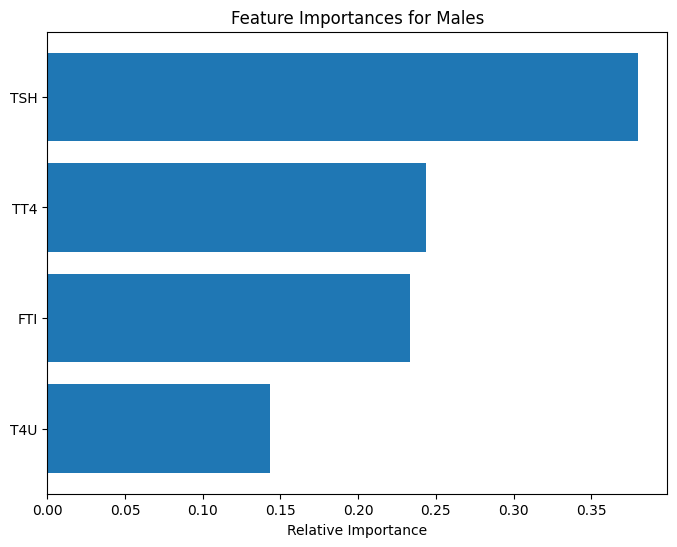

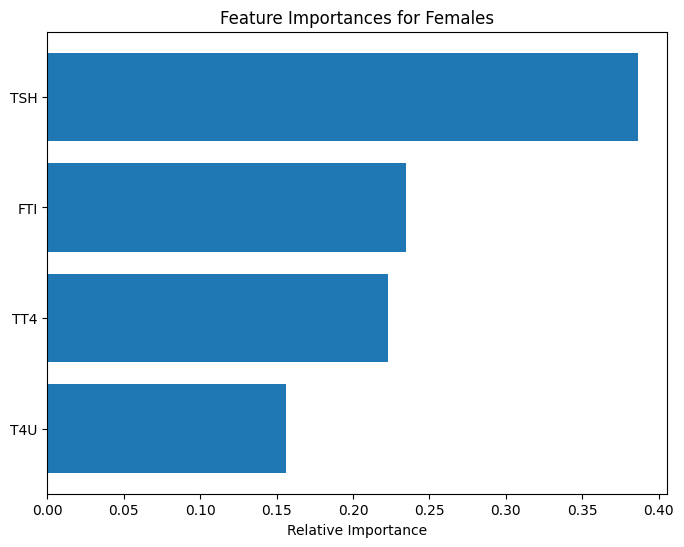

In [19]:
# Splitting the dataset into male and female
df_male = df[df['sex'] == 1]
df_female = df[df['sex'] == 0]

# Selecting relevant features and target for males and females
features = ['TSH', 'TT4', 'T4U', 'FTI']  

X_male = df_male[features]
y_male = df_male['binary_target']

X_female = df_female[features]
y_female = df_female['binary_target']

# Train Random Forest Classifier for males
rf_male = RandomForestClassifier()
rf_male.fit(X_male, y_male)
print("Random Forest trained for males.")

# Train Random Forest Classifier for females
rf_female = RandomForestClassifier()
rf_female.fit(X_female, y_female)
print("Random Forest trained for females.")

# Defining a function to plot feature importances
def plot_feature_importances(model, features, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
# Plotting feature importances
plot_feature_importances(rf_male, features, 'Feature Importances for Males')
plot_feature_importances(rf_female, features, 'Feature Importances for Females')

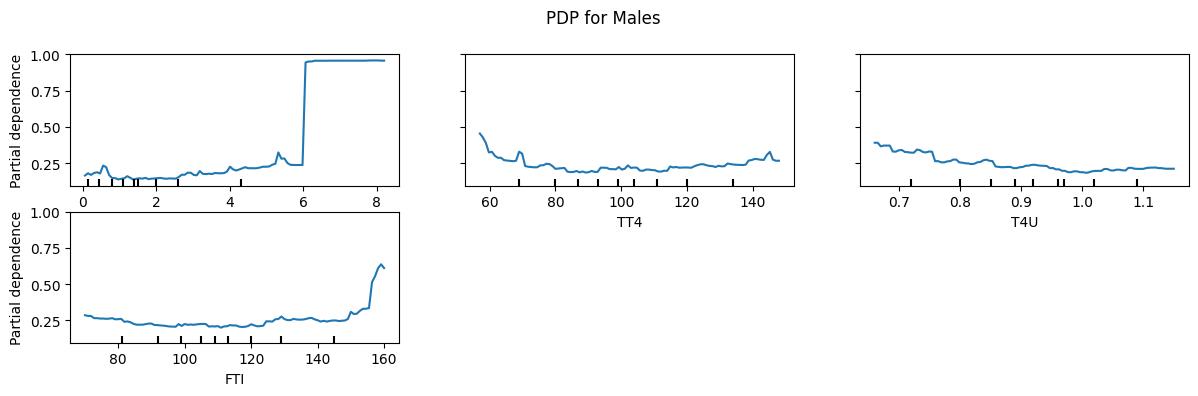

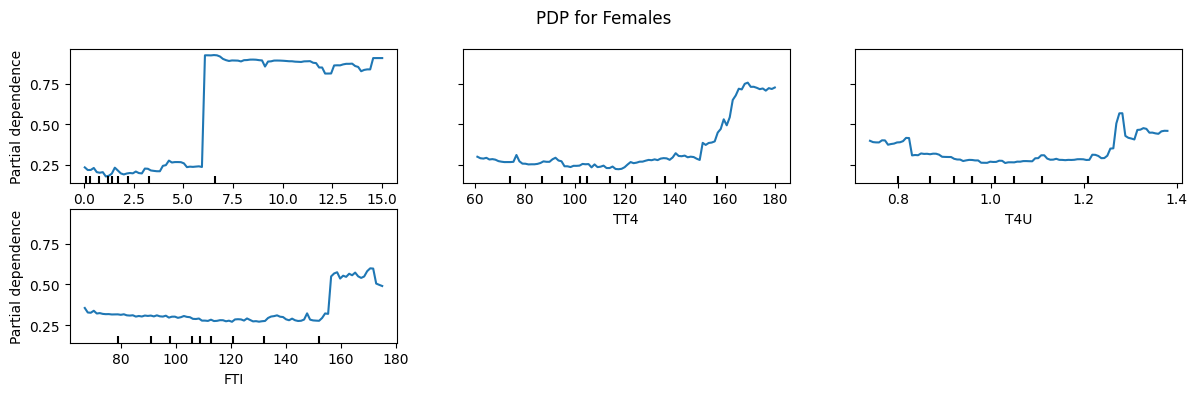

In [20]:
# Defining a function to plot partial dependence plots (PDPs)
def plot_pdps(model, X, features, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    display = PartialDependenceDisplay.from_estimator(model, X, features, ax=ax)
    plt.suptitle(title)
    plt.tight_layout()

# Plotting partial dependence plots
plot_pdps(rf_male, X_male, features, 'PDP for Males')
plot_pdps(rf_female, X_female, features, 'PDP for Females')

***TSH:*** In both males and females, the PDP indicates a sharp increase in the likelihood of disease at a TSH threshold around 6. 

***TT4:*** In males, the PDP indicates a relatively stable likelihood of disease diagnosis, with slight increases at extremely low and extremely high TT4 levels. In females, this trend is more pronounced, indicating an increasing likelihood of disease diagnosis as TT4 increases. 

***FTI:*** In males, the likelihood of disease remains relatively stable across the range of FTI values, with the only significant increase at higher values. In females, the pattern is significantly less stable which may indicate other variable interactions with FTI to influence the target variable 

## A disease prediction model based on lab work

In our binary classification for the target variable based on all attributes, we noticed the most prevalent were hormone levels collected from lab work. Therefore, we trained our models based on only those attributes as well as visualized the random forest decision tree for clinical application. 

In [21]:
# Create a new binary target variable 
disease_columns = [
    'Diagnosis_E', 'Diagnosis_F', 'Diagnosis_FK', 'Diagnosis_G', 'Diagnosis_GI',
    'Diagnosis_GK', 'Diagnosis_GKJ', 'Diagnosis_H', 'Diagnosis_A', 'Diagnosis_AK', 
    'Diagnosis_B', 'Diagnosis_C', 'Diagnosis_D'
]
df['binary_target_hormone'] = df[disease_columns].sum(axis=1) >= 1

# Select hormone level columns as features
features = df[['TSH', 'TT4', 'T4U', 'FTI']]
target = df['binary_target_hormone']

# Train-test split
X_train_hormone, X_test_hormone, y_train_hormone, y_test_hormone = train_test_split(features, target, test_size=0.3, random_state=42)

In [22]:
# Initialize models
rf_hormone = RandomForestClassifier(n_estimators=100)
nn_hormone = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
svm_hormone = SVC(probability=True)
logreg_hormone = LogisticRegression(max_iter=1000)

models = {'Random Forest': rf_hormone, 'Neural Network': nn_hormone, 'SVM': svm_hormone, 'Logistic Regression': logreg_hormone}

# Train models
for name, model in models.items():
    model.fit(X_train_hormone, y_train_hormone)

# Evaluate models
metrics = {'Model': [], 'Accuracy': [], 'Recall': [], 'Precision': [], 'ROC AUC': [], 'FPR': [], 'TPR': []}

for name, model in models.items():
    y_pred = model.predict(X_test_hormone)
    y_proba = model.predict_proba(X_test_hormone)[:, 1]

    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_test_hormone, y_pred))
    metrics['Recall'].append(recall_score(y_test_hormone, y_pred))
    metrics['Precision'].append(precision_score(y_test_hormone, y_pred))
    metrics['ROC AUC'].append(roc_auc_score(y_test_hormone, y_proba))

    fpr, tpr, _ = roc_curve(y_test_hormone, y_proba)
    metrics['FPR'].append(fpr)
    metrics['TPR'].append(tpr)


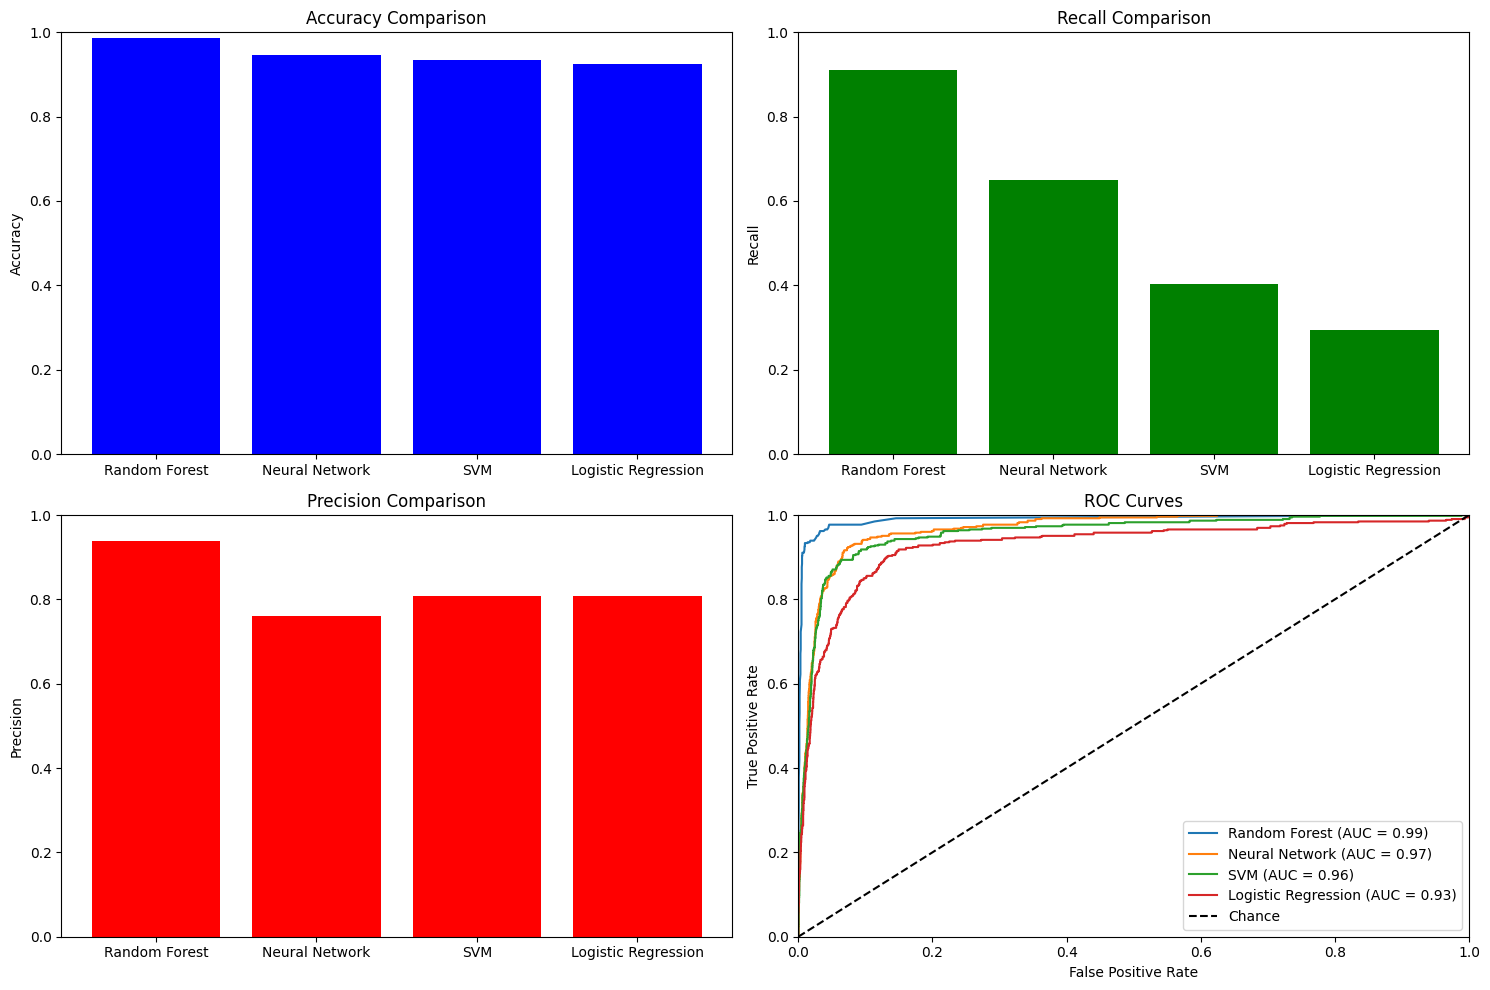

In [23]:
# Plotting metrics
metrics_df = pd.DataFrame(metrics)
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

# Plot Accuracy
axs[0, 0].bar(metrics_df['Model'], metrics_df['Accuracy'], color='blue')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_ylim([0, 1])
axs[0, 0].set_ylabel('Accuracy')

# Plot Recall
axs[0, 1].bar(metrics_df['Model'], metrics_df['Recall'], color='green')
axs[0, 1].set_title('Recall Comparison')
axs[0, 1].set_ylim([0, 1])
axs[0, 1].set_ylabel('Recall')

# Plot Precision
axs[1, 0].bar(metrics_df['Model'], metrics_df['Precision'], color='red')
axs[1, 0].set_title('Precision Comparison')
axs[1, 0].set_ylim([0, 1])
axs[1, 0].set_ylabel('Precision')

# Plot ROC Curves
for i, model in enumerate(models.keys()):
    axs[1, 1].plot(metrics['FPR'][i], metrics['TPR'][i], label=f'{model} (AUC = {metrics["ROC AUC"][i]:.2f})')
axs[1, 1].plot([0, 1], [0, 1], 'k--', label='Chance')
axs[1, 1].set_title('ROC Curves')
axs[1, 1].set_xlim([0, 1])
axs[1, 1].set_ylim([0, 1])
axs[1, 1].set_xlabel('False Positive Rate')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

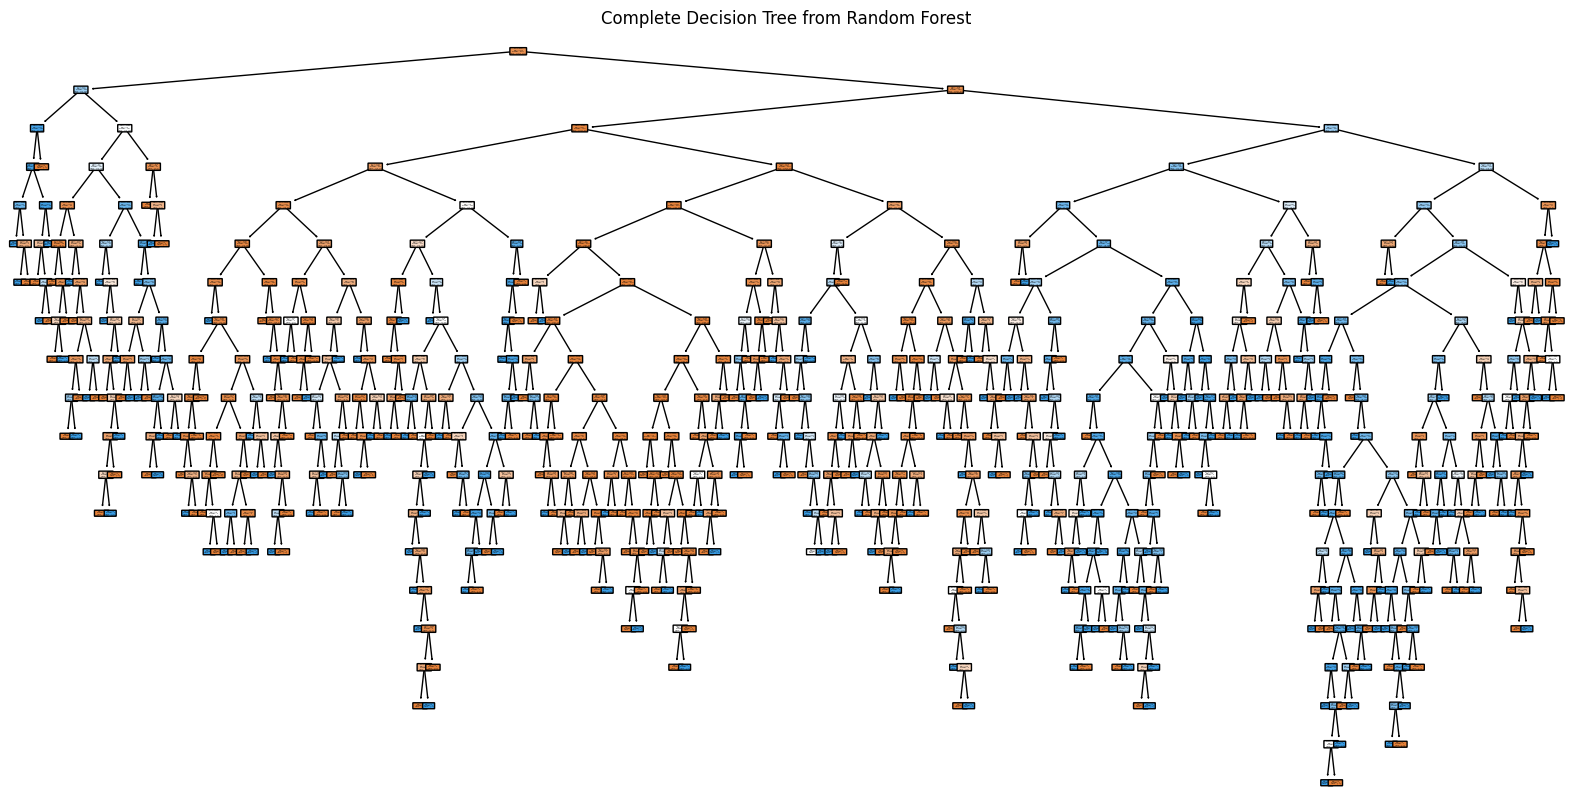

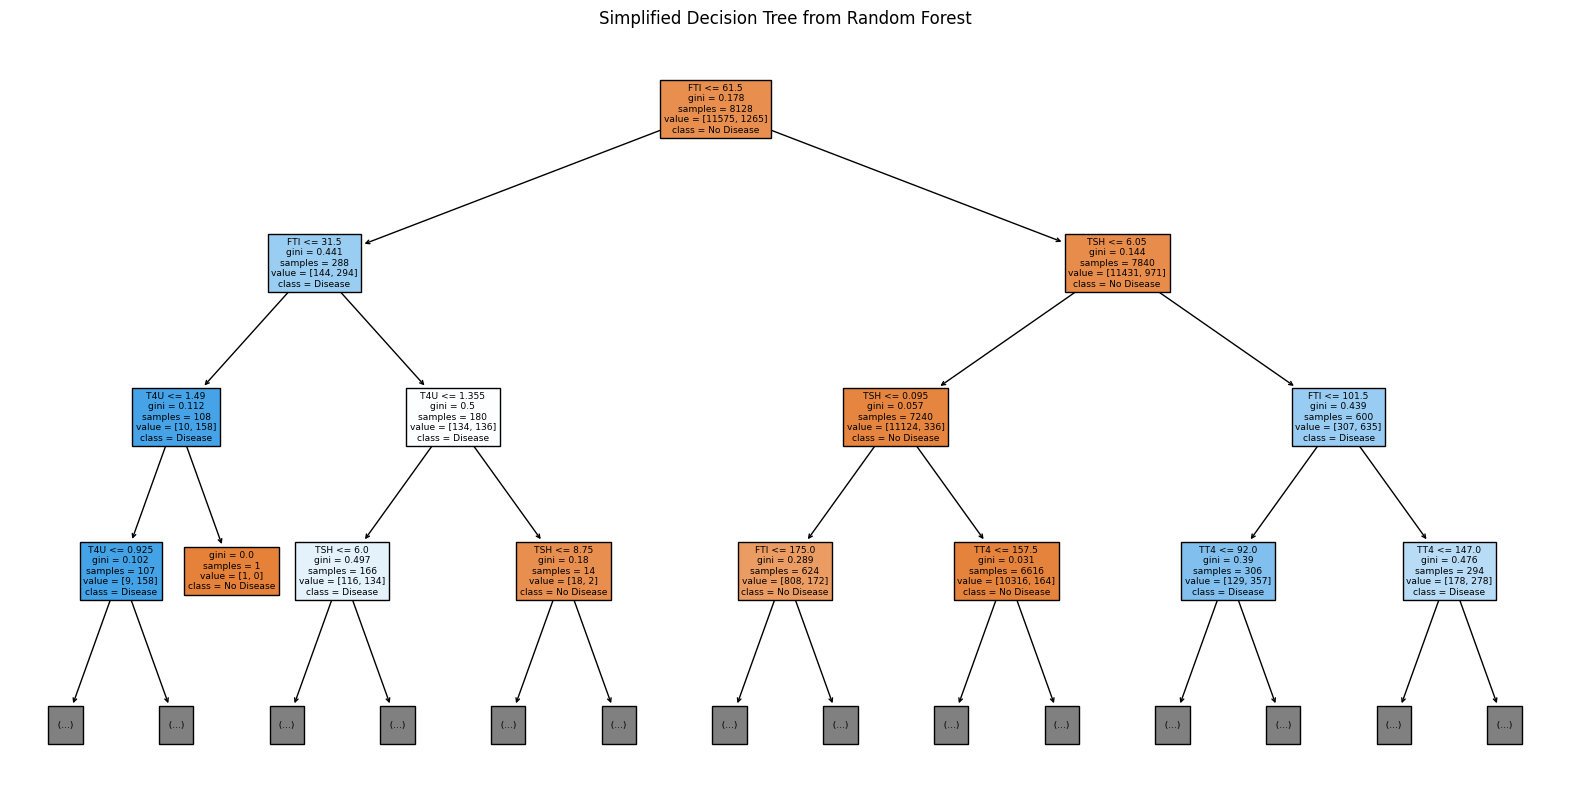

In [24]:
# Visualize first RF tree
estimator = rf_hormone.estimators_[0]
feature_names = ['TSH', 'TT4', 'T4U', 'FTI']
target_names = ['No Disease', 'Disease']

plt.figure(figsize=(20,10))
plot_tree(estimator, 
          feature_names=feature_names, 
          class_names=target_names, 
          filled=True, impurity=True, 
          rounded=True)

plt.title('Complete Decision Tree from Random Forest')
plt.show()

# Zoom in on depth 
plt.figure(figsize=(20,10))
plot_tree(estimator, feature_names=feature_names, class_names=target_names, 
          filled=True, max_depth=3)
plt.title('Simplified Decision Tree from Random Forest')
plt.show()

## A disease prediction model based on patient history and clinical observations

In order to contrast our models based on hormonal lab work, we proposed a model for clinical prediction based on patient history and observable clinical attributes. In order for this model to be used for assessment, the following question should be included in patient history and observation surveys:

1. What sex does patient identify with?
2. What age is the patient?
3. Has the patient undergone I131 treatment?
4. Does the patient believe to have hypothyroidism?
5. Does the patient believe to have hyperthyroidism?
6. Has the patient undergone thyroid surgery?
7. Has the patient previously taken lithium?
8. Is the patient on thyroxine?
9. Is the patient on antithyroid medication?
10. Does the patient have Goitre?
11. Does the patient have any psychological conditions? 
12. Is the patient pregnant? 
13. Is the patient currently sick? 

In [25]:
# Create a new binary target variable 
disease_columns = [
    'Diagnosis_E', 'Diagnosis_F', 'Diagnosis_FK', 'Diagnosis_G', 'Diagnosis_GI',
    'Diagnosis_GK', 'Diagnosis_GKJ', 'Diagnosis_H', 'Diagnosis_A', 'Diagnosis_AK', 
    'Diagnosis_B', 'Diagnosis_C', 'Diagnosis_D'
]
df['binary_target_eval'] = df[disease_columns].sum(axis=1) >= 1

# Select patient history columns as features
features = df[['sex', 'age', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'thyroid_surgery', 'lithium', 'on_thyroxine', 'on_antithyroid_meds', 'goitre', 'psych', 'pregnant', 'sick']]
target = df['binary_target_hormone']

# Train-test split
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(features, target, test_size=0.3, random_state=42)

In [26]:
# Initialize models
rf_eval = RandomForestClassifier(n_estimators=100)
nn_eval = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
svm_eval = SVC(probability=True)
logreg_eval = LogisticRegression(max_iter=1000)

models = {'Random Forest': rf_eval, 'Neural Network': nn_eval, 'SVM': svm_eval, 'Logistic Regression': logreg_eval}

# Train models
for name, model in models.items():
    model.fit(X_train_eval, y_train_eval)

# Evaluate models
metrics = {'Model': [], 'Accuracy': [], 'Recall': [], 'Precision': [], 'ROC AUC': [], 'FPR': [], 'TPR': []}

for name, model in models.items():
    y_pred = model.predict(X_test_eval)
    y_proba = model.predict_proba(X_test_eval)[:, 1]

    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_test_eval, y_pred))
    metrics['Recall'].append(recall_score(y_test_eval, y_pred))
    metrics['Precision'].append(precision_score(y_test_eval, y_pred))
    metrics['ROC AUC'].append(roc_auc_score(y_test_eval, y_proba))

    fpr, tpr, _ = roc_curve(y_test_eval, y_proba)
    metrics['FPR'].append(fpr)
    metrics['TPR'].append(tpr)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


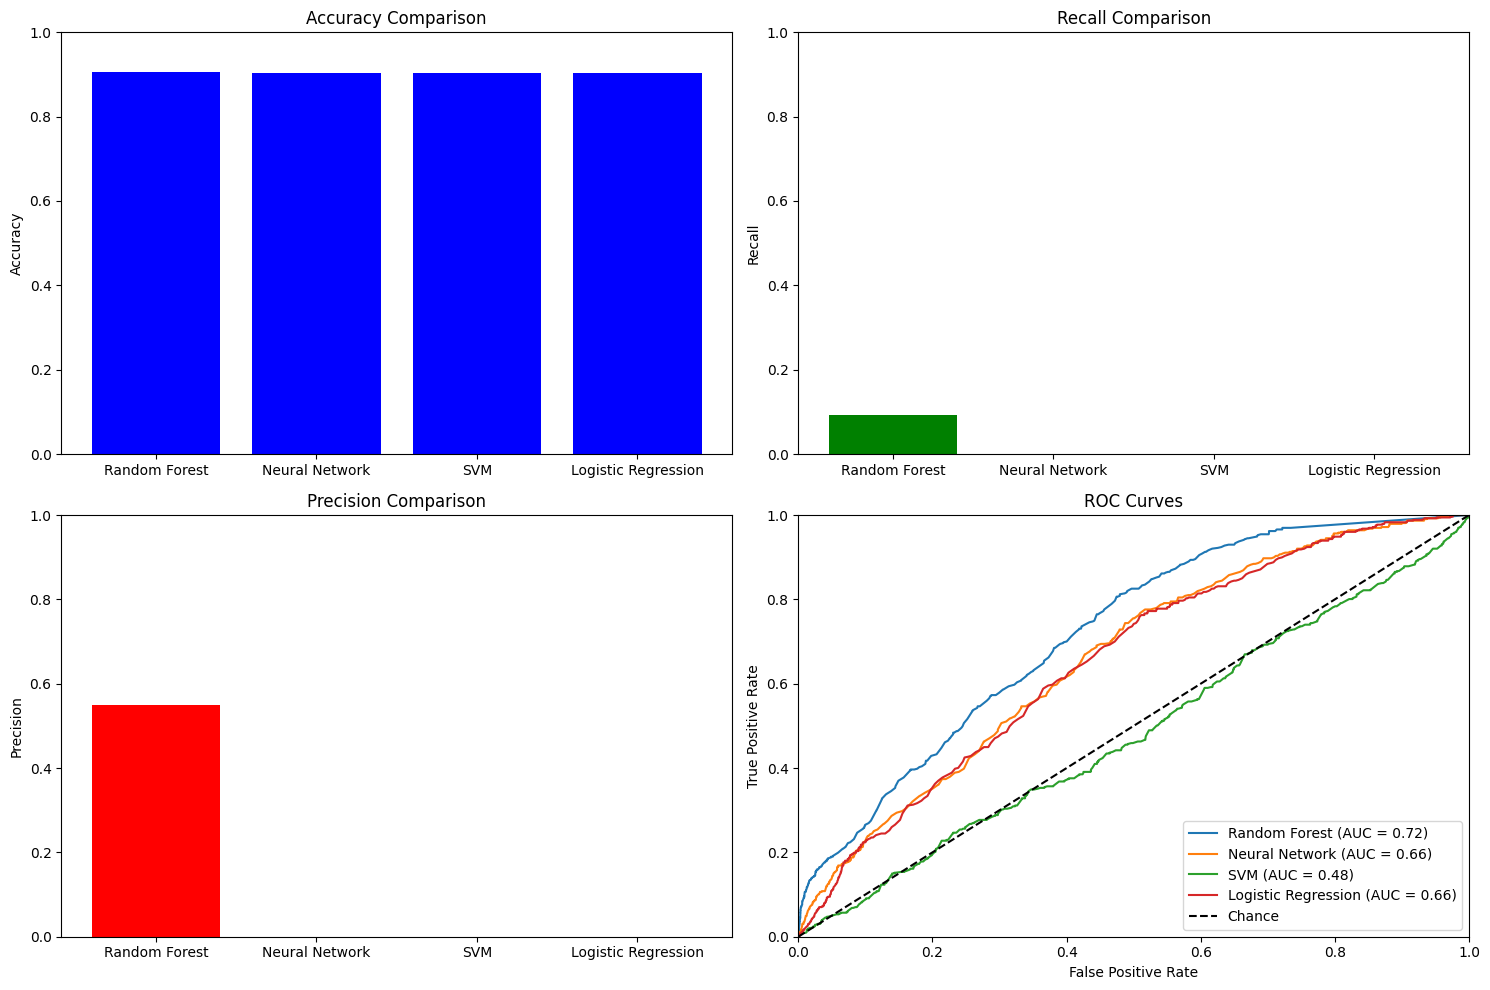

In [27]:
# Plotting metrics
metrics_df_eval = pd.DataFrame(metrics)
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

# Plot Accuracy
axs[0, 0].bar(metrics_df_eval['Model'], metrics_df_eval['Accuracy'], color='blue')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_ylim([0, 1])
axs[0, 0].set_ylabel('Accuracy')

# Plot Recall
axs[0, 1].bar(metrics_df_eval['Model'], metrics_df_eval['Recall'], color='green')
axs[0, 1].set_title('Recall Comparison')
axs[0, 1].set_ylim([0, 1])
axs[0, 1].set_ylabel('Recall')

# Plot Precision
axs[1, 0].bar(metrics_df_eval['Model'], metrics_df_eval['Precision'], color='red')
axs[1, 0].set_title('Precision Comparison')
axs[1, 0].set_ylim([0, 1])
axs[1, 0].set_ylabel('Precision')

# Plot ROC Curves
for i, model in enumerate(models.keys()):
    axs[1, 1].plot(metrics['FPR'][i], metrics['TPR'][i], label=f'{model} (AUC = {metrics["ROC AUC"][i]:.2f})')
axs[1, 1].plot([0, 1], [0, 1], 'k--', label='Chance')
axs[1, 1].set_title('ROC Curves')
axs[1, 1].set_xlim([0, 1])
axs[1, 1].set_ylim([0, 1])
axs[1, 1].set_xlabel('False Positive Rate')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

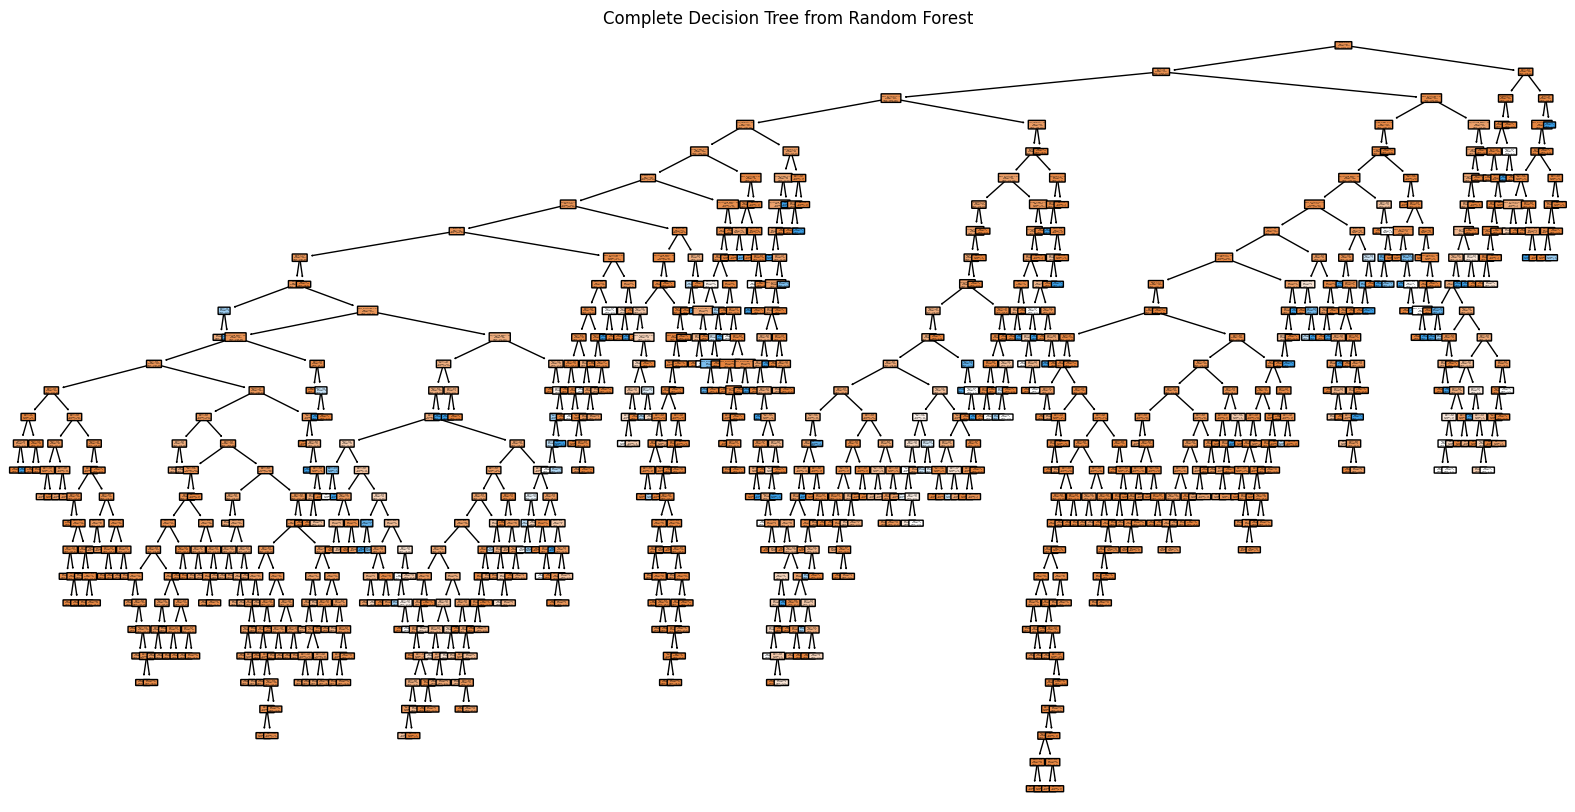

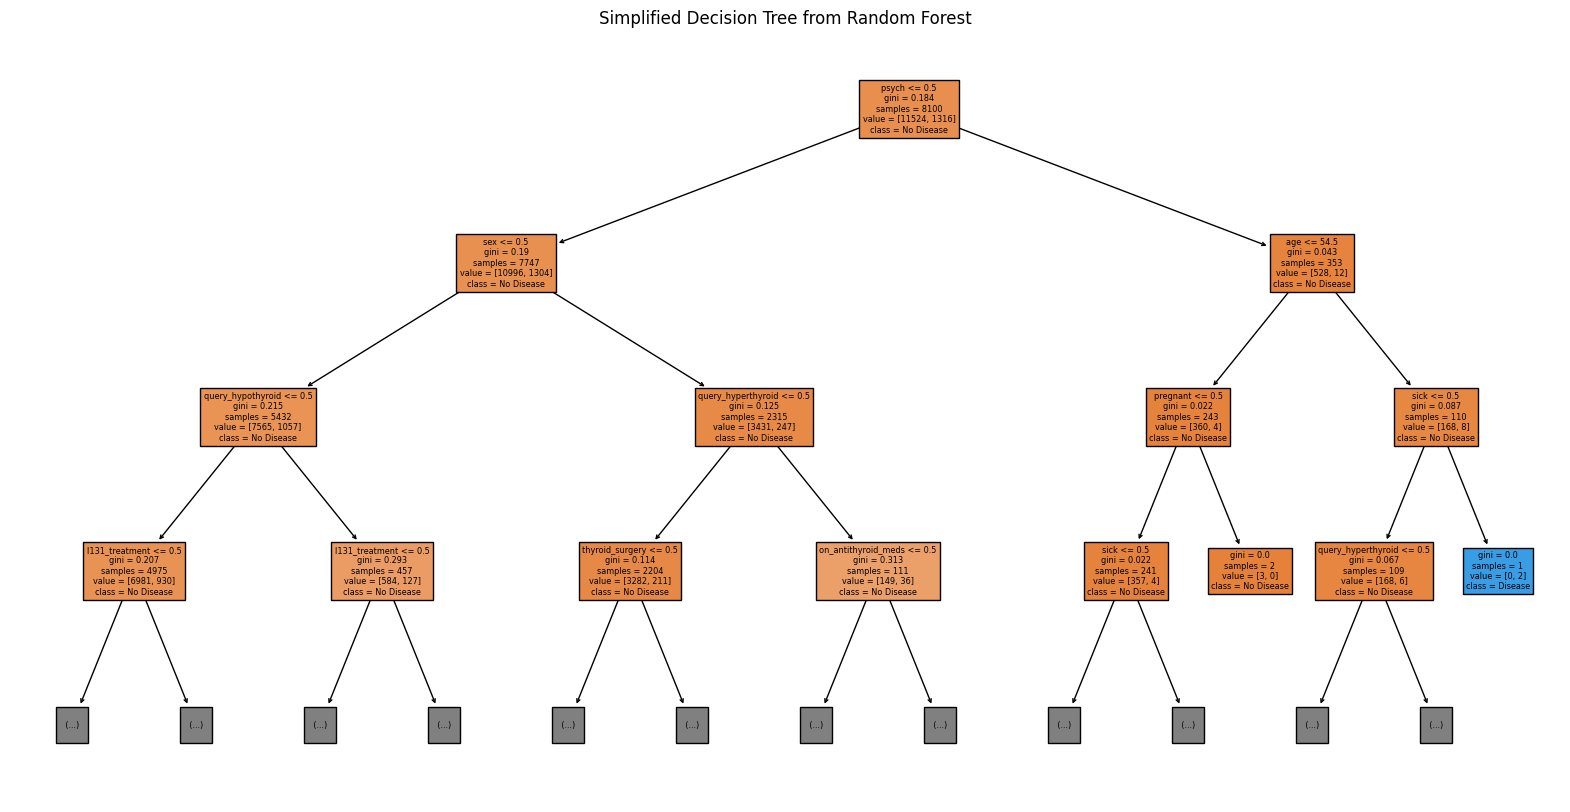

In [28]:
# Visualize first RF tree
estimator = rf_eval.estimators_[0]
feature_names = ['sex', 'age', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'thyroid_surgery', 'lithium', 'on_thyroxine', 'on_antithyroid_meds', 'goitre', 'psych', 'pregnant', 'sick']
target_names = ['No Disease', 'Disease']

plt.figure(figsize=(20,10))
plot_tree(estimator, 
          feature_names=feature_names, 
          class_names=target_names, 
          filled=True, impurity=True, 
          rounded=True)

plt.title('Complete Decision Tree from Random Forest')
plt.show()

# Zoom in on depth 
plt.figure(figsize=(20,10))
plot_tree(estimator, feature_names=feature_names, class_names=target_names, 
          filled=True, max_depth=3)
plt.title('Simplified Decision Tree from Random Forest')
plt.show()